In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import cluster

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.cdnmf_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition._nmf import NMF
import math
import seaborn as sns
from matplotlib.patches import Rectangle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique 
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder



/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')

annotation/ccf_2017


In [7]:
#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)

def fix_pdcsv(csv):
    
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

def get_colors(structures, palettes, alpha):
    
    strs_unique = np.unique(structures)
    nstr = len(strs_unique)
    cs = sns.color_palette("Spectral", nstr)
    
    #print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
    cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
    color_str = {}
    for i in range(nstr):
        #print(i)
        color_str[strs_unique[i]] = cs_alphas[i]
    #print(color_str['CB'])
    #print(color_str)
    output = np.zeros((len(structures),4), dtype  =float)
    for i in range(len(structures)):
        #print(np.asarray(color_str[structures[i]]))
        output[i] = np.asarray(color_str[structures[i]])
        
    return(output,color_str)

wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428.csv',  header=[0,1])
wt_conn = fix_pdcsv(wt_conn)
#dists = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv',  header=[0,1])
#dists = fix_pdcsv(dists)

In [9]:
distances_leaf_leaf = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances_leaf_leaf.npy')

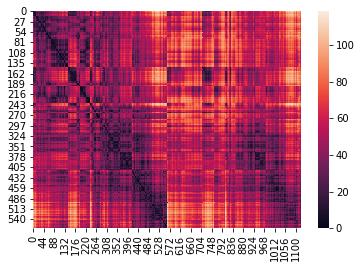

In [10]:
sns.heatmap(distances_leaf_leaf)

In [ ]:
wt_conn = wt_conn.loc[dists.index]
wt_conn = wt_conn.loc[:,dists.columns]